<a href="https://colab.research.google.com/github/EmYassir/rl_optimal_control/blob/main/iterative_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Experiment

### (a) 

In this section, we have implemented the following:

1.   The policy evaluation operator.
2.   The Bellman optimality operator.
3.   The smooth Bellman optimality operator.
4.   The policy iteration operator.
5.   The smooth policy iteration operator.
6.   The Newton-Kantorovich iteration operator.

For each of the functions above, we have implemented a small test to ensure they are working properly. 



#### Libraries

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from timeit import default_timer as timer
from jax import jvp
import jax.numpy as np
from jax.scipy.special import logsumexp
from jax.experimental.stax import softmax
from jax.ops import index, index_update
from jax.config import config
config.update("jax_enable_x64", True) # To have 64-bit floats/ints

#### Utility functions

This section implements some utility functions we are going to use all along this practical part.

##### Data generation

In [ ]:
def generate_mdp():
  """
  This function is only used to generate the MDP described in the assignment
  """
  R = np.array([[5., 10.], [-1, 1]])
  P = np.array([[[0.5, 0.5], [0.5, 0.5]], [[0, 1], [0.5, 0.5]]])

  # Discount factor
  gamma = 0.9

  # Converting everything to jax
  return P, R, gamma


##### Default termination condition

In [ ]:
def default_criterion(prev, curr, epsilon=1e-8):
  """
  This function is used as a termination indicator for our iterative methods
  """
  return np.linalg.norm(prev - curr) < epsilon

##### Successive approximations routines

In [ ]:
def step(init_guess, operator, criterion):
  """
  This function is similar to an iterator. Applies the operator once and tests with respect to
  the termination condition. Loops infinitely until the termination condition becomes 'True'.
  """
  prev, curr = init_guess,operator(init_guess), 
  yield curr
  while not criterion(prev, curr):
      prev, curr = curr, operator(curr)
      yield curr

def successive_approximation(init_guess, operator=lambda x: x, criterion=lambda prev, curr: False, trace_back = None):
    """
    This function uses the previous one to performs multiple iterations until the termination condition is True.
    """
    for iterate in step(init_guess, operator, criterion):
      if trace_back is not None:
        trace_back.append(iterate)
    return iterate

##### Comparison function (for testing)

In [ ]:
def approximation_test(value1, value2, verbose = False):
  """
  This function compares the values given as arguments.
  """
  test = np.allclose(value1, value2)
  if test: 
    print('### Success !!!')
    if verbose:
      print('value 1 = ', value1)
      print('value 2 = ', value2)
  else:
    print('### Failure !!!')
    print('value 1 = ', value1)
    print('value 2 = ', value2)


##### Direct policy evaluator (for testing)

In [ ]:
def run_iterative_solver(A, b):
  """ 
  Solves Ax = b in a matrix-free way.
  """
  def operator(x):
    return np.einsum('ij, j -> i', np.eye(A.shape[0]) - A, x) + b
  return successive_approximation(np.zeros(b.shape), operator, default_criterion)


def direct_policy_evaluation(P, R, discount, policy, iterative = False):
  """ 
  Solves the MDP directly (either iteratively or by computing a matrix inverse). 
  Used for testing only.
  """
  result = None
  Pb = np.einsum('ast,sa->st', P, policy)
  Rb = np.einsum('sa,sa->s', R, policy)
  A, b = np.eye(P.shape[-1]) - discount*Pb, Rb
  if iterative == True:
    # Iterative
    return run_iterative_solver(A, b)
  else:
    # Explicit inverse
    return np.linalg.solve(A, b)


###### Quick test for direct policy evaluator

In [ ]:
"""
The purpose of this test is to ensure the iterative evaluation function works well. Due to the relative smallness 
of matrices sizes, calculating the inverse seems to run faster than approximating it iteratively. From now on, we 
are going to make use of the numpy built-in solver (with the explicit inverse calculation).
"""

P, R, gamma = generate_mdp()
na, ns = P.shape[0], P.shape[1]
policy = 0.5 * np.ones((ns, na))

ref = direct_policy_evaluation(P, R, gamma, policy, iterative = False)
res = direct_policy_evaluation(P, R, gamma, policy, iterative = True)

approximation_test(ref, res, verbose = True)

### Success !!!
value 1 =  [33.67346939 27.55102041]
value 2 =  [33.67346933 27.55102035]


#### Policy evaluation operator

In [ ]:
def get_policy_evaluation_operator(P, R, discount, policy):
  """
  This function implements the policy evaluation operator.
  """
  def operator(v):
    T = np.einsum('ast,sa->st', P, policy)
    r = np.einsum('sa,sa->s', R, policy)
    v =  r + discount * np.einsum('st,t->s', T, v)
    return v
  return operator

##### Quick test

In [ ]:
""" 
The purpose of this test is to ensure the policy evaluation operator works well.
"""

P, R, gamma = generate_mdp()
na, ns = P.shape[0], P.shape[1]
policy = 0.5 * np.ones((ns, na))

operator = get_policy_evaluation_operator(P, R, gamma, policy)

res = successive_approximation(np.zeros((ns,)), operator, default_criterion)
ref = direct_policy_evaluation(P, R, gamma, policy)

approximation_test(ref, res, verbose = True)

### Success !!!
value 1 =  [33.67346939 27.55102041]
value 2 =  [33.67346933 27.55102035]


#### Bellman optimality operators

##### Bellman optimality operator

In [ ]:
def get_bellman_optimality_operator(P, R, discount):
  """
  This function implements the Bellman optimality operator.
  """
  def operator(v):
    v =  R + discount * np.einsum('ast,t->sa', P, v)
    v = np.max(v, axis = 1)
    return v
  return operator

##### Smooth Bellman optimality operator

In [ ]:
def get_smooth_bellman_optimality_operator(P, R, discount, temperature):
  """
  This function implements the smooth Bellman optimality operator.
  """
  def operator(v):
    v = temperature * logsumexp((1/temperature) *(R + discount * np.einsum('ast,t->sa', P, v)), axis = 1)
    return v
  return operator

##### Quick test

In [ ]:
""" 
The purpose of this test is to ensure the Bellman operators work well.
"""

tau = 1e-5
P, R, gamma = generate_mdp()
na, ns = P.shape[0], P.shape[1]

hard_operator = get_bellman_optimality_operator(P, R, gamma)
smooth_operator = get_smooth_bellman_optimality_operator(P, R, gamma, tau)

# The policy here should be optimal (we know its value)
policy = np.array([[0., 1.], [0., 1.]])
ref = direct_policy_evaluation(P, R, gamma, policy)

for operator in [hard_operator, smooth_operator]:
  res = successive_approximation(np.zeros((ns,)), operator, default_criterion)
  approximation_test(ref, res, verbose = True)

### Success !!!
value 1 =  [44.13793103 37.93103448]
value 2 =  [44.13793098 37.93103442]
### Success !!!
value 1 =  [44.13793103 37.93103448]
value 2 =  [44.13793098 37.93103442]


#### Policy iteration operators

##### Policy iteration operator

In [ ]:
def get_policy_iteration_operator(P, R, discount): 
  """ 
  This function implements the policy iteration procedure. 
  """ 
  def operator(policy): 
    """ 
    This is the core of the algorithm: policy evaluation/improvement. 
    """
    # Policy evaluation
    pol_eval_operator = get_policy_evaluation_operator(P, R, discount, policy)
    v = successive_approximation(np.zeros((policy.shape[0],)), pol_eval_operator, default_criterion)
    
    # Policy improvement
    q =  R + discount * np.einsum('ast,t->sa', P, v)
    new_policy = np.zeros(policy.shape)
    new_policy = index_update(new_policy, index[:, np.argmax(q, axis = 1)], 1)
    return np.array(new_policy)
  return operator

def policy_iteration_criterion(prev, curr): 
  """ 
  The criterion will be different this time, as it involves policies. 
  """ 
  return (prev == curr).all()


##### Smooth policy iteration operator

In [ ]:
def get_smooth_policy_iteration_operator(P, R, discount, temperature):
  """ 
  This function implements the smooth policy iteration procedure. 
  """ 
  def operator(policy):
    """ 
    This time, we apply softmax function instead of hard argmax. 
    """
    # Policy evaluation
    pol_eval_operator = get_policy_evaluation_operator(P, R, discount, policy)
    v = successive_approximation(np.zeros((policy.shape[0],)), pol_eval_operator, default_criterion)
    
    # Policy improvement
    new_policy =  softmax((1/temperature) * (R + discount * np.einsum('ast,t -> sa', P, v)))
    return new_policy
  return operator

##### Quick test

In [ ]:
""" 
The purpose of this test is to ensure the policy iteration operators find the correct policy.
"""

P, R, gamma = generate_mdp()
na, ns = P.shape[0], P.shape[1]
tau = 1e-5

operator = get_policy_iteration_operator(P, R, gamma)
smooth_operator = get_smooth_policy_iteration_operator(P, R, gamma, tau)

print('=> Proceeding with policy iteration...')
pol1 = successive_approximation(np.zeros((ns, na)), operator, policy_iteration_criterion)
print('*** Optimal policy found is')
print(pol1)

print('=> Proceeding with smooth policy iteration...')
pol2 = successive_approximation(np.zeros((ns, na)), smooth_operator, policy_iteration_criterion)
print('*** Optimal policy found is')
print(pol2)

print('=> Testing optimal policies found...')
approximation_test(pol1, pol2, verbose = False)

print('=> Testing with direct evaluation...')
for policy in [pol1, pol2]:
  operator = get_policy_evaluation_operator(P, R, gamma, policy)
  res = successive_approximation(np.zeros((ns,)), operator, default_criterion)
  ref = direct_policy_evaluation(P, R, gamma, policy)
  approximation_test(ref, res, verbose = True)

=> Proceeding with policy iteration...
*** Optimal policy found is
[[0. 1.]
 [0. 1.]]
=> Proceeding with smooth policy iteration...
*** Optimal policy found is
[[0. 1.]
 [0. 1.]]
=> Testing optimal policies found...
### Success !!!
=> Testing with direct evaluation...
### Success !!!
value 1 =  [44.13793103 37.93103448]
value 2 =  [44.13793098 37.93103442]
### Success !!!
value 1 =  [44.13793103 37.93103448]
value 2 =  [44.13793098 37.93103442]


#### Newton-Kantorovich iterations

##### Gateaux-derivative

In [ ]:
def get_gateaux_derivative(P, R, discount, temperature):
  """ 
  This function implements the Gateaux-derivative operator. As the derivative is 
  calculated at v in the direction of w, this operator takes 2 arguments (vectors).
  """ 
  def diff_at(v):
    d = softmax((1/temperature) * (R + discount * np.einsum('ast,t -> sa', P, v)))
    def diff_direction(w):
      return discount * np.einsum('sa,ast,t -> s', d, P, w)
    return diff_direction
  return diff_at

###### Quick test

In [ ]:
""" 
The purpose of this test is to make sure the Gateaux-Derivative operator works well.
"""
tau = 1e-5
P, R, gamma = generate_mdp()
na, ns = P.shape[0], P.shape[1]

# We can pick any values
v = np.array([1.,2.])
w = np.array([3.,4.])

operator = get_smooth_bellman_optimality_operator(P, R, gamma, tau)
_, ref = jvp(operator, (v, ), (w,))

res = get_gateaux_derivative(P, R, gamma, tau)(v)(w)
approximation_test(ref, res, verbose = True)

### Success !!!
value 1 =  [3.6  3.15]
value 2 =  [3.6  3.15]


##### Newton-Kantorovitch iterations

In [ ]:
def run_nk_iterative_solver(A, b):
  """ 
  Solves Ax = b (Same as our previous iterative solver). The difference is that this time, 
  we assume that A is an operator (callable).
  """
  def operator(x):
    return A(x) + b
  return successive_approximation(np.zeros(b.shape), operator, default_criterion)


def get_newton_kantorovich_operator(operator, gateaux_derivative):
  """ 
  Implements Newton-Kantorovich method in a matrix-free way (with the iterative solver defined above).
  """
  def newton_kantorovich(v):
    A = gateaux_derivative(v)
    b = operator(v) - A(v)
    return run_nk_iterative_solver(A, b)
  return newton_kantorovich

###### Quick test

In [ ]:
""" 
We now have to make sure the NK iterations work well as a whole.
"""
tau = 1e-5
P, R, gamma = generate_mdp()
na, ns = P.shape[0], P.shape[1]
# We pick the optimal policy
policy = [[0., 1.], [0., 1.]] 


smooth_operator = get_smooth_bellman_optimality_operator(P, R, gamma, tau)
gateaux_derivative = get_gateaux_derivative(P, R, gamma, tau)
nk_operator = get_newton_kantorovich_operator(smooth_operator, gateaux_derivative)

res = successive_approximation(np.zeros((ns,)), nk_operator, default_criterion)
ref = direct_policy_evaluation(P, R, gamma, policy)

approximation_test(ref, res, verbose = True)

### Success !!!
value 1 =  [44.13793103 37.93103448]
value 2 =  [44.13793098 37.93103442]


### (b) 

In this section, we have implemented LP formulation corresponding to the MDP problem given in the assignment


#### Linear Programming formulation

In [ ]:
def solve_lp(P, R, discount, init_dist, solver = 'revised simplex',  trace_back_list = []):
  """ 
  Solves the discounted MDP defined by P, R and gamma as an LP problem.
  """
  def extract_coefficients(P, R, discount):
    """ 
    Function used to compute A and b for the LP program.
    """
    ns, na = P.shape[0], P.shape[1]
    A = np.zeros((ns * na, ns))
    A = -discount * np.reshape(P, (ns * na, ns))
    A = index_update(A, index[[1, 2]], A[[2, 1]])
    
    # Building A
    start_idx, end_idx = 0, na
    for s in range(ns):
      for sa in range(start_idx, end_idx):
        A = index_update(A, index[sa, s], 1. + A[sa, s])
      start_idx += end_idx
      end_idx += end_idx
    
    # Building b
    b = R.flatten()
    return -A, -b
  
  def get_collect_operator(list_trace_back):
    """ 
    Callback function used to gather the values generated by the iterative procedure.
    """
    def operator(object):
      list_trace_back.append(object.x)
    return operator
  
  # Main program
  A, b = extract_coefficients(P, R, gamma)
  sol = linprog(init_dist, A_ub = A, b_ub= b, bounds=(None,None), method=solver, callback=get_collect_operator(trace_back_list), x0 = np.zeros(init_dist.shape))
  return sol.x


##### Quick test

In [ ]:
""" 
We test if the LP gives the correct result.
"""
P, R, gamma = generate_mdp()
ns, na = P.shape[0], P.shape[1]
init_dist = 0.5 * np.ones((ns,))

res = solve_lp(P, R, gamma, init_dist, solver = 'revised simplex')
ref = direct_policy_evaluation(P, R, gamma, policy)
approximation_test(ref, res, verbose = True)


### Success !!!
value 1 =  [44.13793103 37.93103448]
value 2 =  [44.13793103 37.93103448]


### (c) 

In this section, we are going to plot the polytopes corresponding to the iterations performed by all the above algorithms. For better visualization, we are also going to plot the polygon corresponding to the feasible set boundaries.

#### Plotting

##### We draw the polygon corresponding to the feasible set (all solutions should be inside)

In [ ]:
def set_plot_env():
  """ 
  Function used to set up the matplotlib environment.
  """
  mpl.rcdefaults()
  mpl.rcParams['mathtext.default']= 'regular'
  mpl.rcParams['font.size'] = 18.
  mpl.rcParams['font.family'] = 'Arial'
  mpl.rcParams['font.weight'] = "normal"
  mpl.rcParams['axes.labelsize'] = 18.
  mpl.rcParams['xtick.labelsize'] = 18
  mpl.rcParams['ytick.labelsize'] = 18
  
  mpl.rcParams['xtick.major.width'] = 0.6
  mpl.rcParams['ytick.major.width'] = 0.6
  mpl.rcParams['axes.linewidth'] = 0.6
  mpl.rcParams['pdf.fonttype'] = 3
  
  mpl.rcParams["xtick.minor.visible"] = "on"
  mpl.rcParams["xtick.direction"] = "in"
  mpl.rcParams["xtick.top"] = "on"
  mpl.rcParams["xtick.major.size"] = 8
  mpl.rcParams["xtick.minor.size"] = 5
  
  mpl.rcParams["ytick.minor.visible"] = "on"
  mpl.rcParams["ytick.direction"] = "in"
  mpl.rcParams["ytick.major.size"] = 8
  mpl.rcParams["ytick.minor.size"] = 5
  mpl.rcParams["ytick.right"] = "on"





def plot_trajectories(boundaries, trajectories = [], labels = [], colors = [], xmin = 0, xmax = 45, ymin = 0, ymax =40):
  """ 
  This function draws the trajectories passed in arguments, all along with the feasible set boundaries.
  """
  fig , axes = plt.subplots(1,1,figsize=(11,10)) 
  fig.subplots_adjust(left=0.18, right=.9, bottom=0.15, top=0.9);
  plt.ylim(ymin, ymax)
  plt.xlim(xmin, xmax)
  
  # Plot the feasible set boundaries
  axes.add_patch(mpl.patches.Polygon(boundaries, closed=True, facecolor='yellow', fill=False, lw = 1.5, edgecolor='gold'))
  
  # Plot the trajectories
  for i, trajectory in enumerate(trajectories):
    t = np.array(trajectory)
    XX = axes.scatter(t[:, 0], t[:, 1], c=colors[i], label=labels[i])

  leg1 = axes.legend(loc='best')
  axes.add_artist(leg1)
  plt.show()
  plt.clf()



##### Plotting the trajectories all together

==>> 1. Policy iterations
*** Generated 2 elements. Execution time: 6.59 seconds
==>> 2. Smooth policy iterations
*** Generated 2 elements. Execution time: 6.58 seconds
==>> 3. Value iterations
*** Generated 193 elements. Execution time: 2.93 seconds
==>> 4. Smooth value iterations
*** Generated 193 elements. Execution time: 4.00 seconds
==>> 5. Newton Kantorovich iterations
*** Generated 2 elements. Execution time: 7.16 seconds
==>> 6. Simplex iterations
*** Generated 6 elements. Execution time: 0.05 seconds


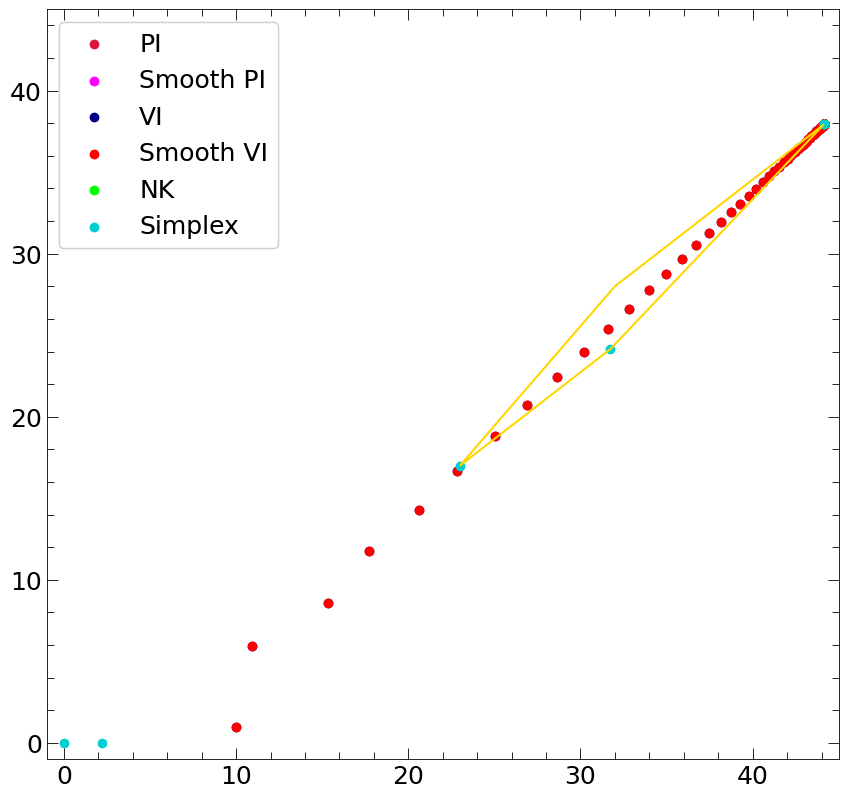

<Figure size 640x480 with 0 Axes>

In [ ]:
tau = 1e-5
P, R, gamma = generate_mdp()
ns, na = P.shape[0], P.shape[1]
init_dist = 0.5 * np.ones((ns,))

# Boundaries of the feasible set
boundaries = np.array([[23., 17.],[31.72413793, 24.13793103],[44.13793103, 37.93103448],[32., 28.]])


# Policy iteration
print('==>> 1. Policy iterations')
start = timer()
pi = []
operator = get_policy_iteration_operator(P, R, gamma)
successive_approximation(np.zeros((ns, na)), operator, policy_iteration_criterion, pi)
for i in range(len(pi)):
  pi[i] = direct_policy_evaluation(P, R, gamma, pi[i])
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(pi), end - start))

# Smooth policy iteration
print('==>> 2. Smooth policy iterations')
start = timer()
spi = []
operator = get_smooth_policy_iteration_operator(P, R, gamma, tau)
successive_approximation(np.zeros((ns, na)), operator, policy_iteration_criterion, spi)
for i in range(len(spi)):
  spi[i] = direct_policy_evaluation(P, R, gamma, spi[i])
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(spi), end - start))

# Value iteration
print('==>> 3. Value iterations')
start = timer()
vi = []
operator = get_bellman_optimality_operator(P, R, gamma)
successive_approximation(np.zeros((ns,)), operator, default_criterion, vi)
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(vi), end - start))

# Smooth value iteration
print('==>> 4. Smooth value iterations')
start = timer()
svi = []
operator = get_smooth_bellman_optimality_operator(P, R, gamma, tau)
successive_approximation(np.zeros((ns,)), operator, default_criterion, svi)
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(svi), end - start))

# Newton-Kantorovich iterations
print('==>> 5. Newton Kantorovich iterations')
start = timer()
nk = []
smooth_operator = get_smooth_bellman_optimality_operator(P, R, gamma, tau)
gateaux_derivative = get_gateaux_derivative(P, R, gamma, tau)
operator = get_newton_kantorovich_operator(smooth_operator, gateaux_derivative)
successive_approximation(np.zeros((ns,)), operator, default_criterion, nk)
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(nk), end - start))

# LP 
print('==>> 6. Simplex iterations')
sim = []
start = timer()
res = solve_lp(P, R, gamma, init_dist, solver = 'revised simplex', trace_back_list = sim)
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(sim), end - start))

# Data sets

trajectories = [pi, spi, vi, svi, nk, sim]
labels = ['PI', 'Smooth PI', 'VI', 'Smooth VI', 'NK', 'Simplex']
colors = ['crimson', 'magenta', 'darkblue', 'red', 'lime', 'darkturquoise']


# Set the matplotlib environment
set_plot_env()

# Plot the trajectories
plot_trajectories(boundaries, trajectories, labels, colors, -1, 45, -1, 45)

Drawing trajectories all together is not very practical with this partical MDP as some of them overlap with each other. Yet, we can make some first observations:


1. Each of PI, smooth PI and NK solve the problem almost immediately. They do two iterations around the optimal value before terminating. 
2. VI and smooth VI overlap. They go over the very same points, starting from beyond the feasible set boundaries before converging to the optimal point.
3. The simplex algorithm starts from beyond the boundaries but quickly converges to the optimal value.
4. The VI operator perform much more steps than other algorithms.

Before getting further in the visualization, here are some comments on the observations above:
1. The closeness between the smooth and non-smooth operators is certainly due to the temperature we initially have chosen ($\tau \approx 10^{-5}$). Indeed, the smaller the temperature, the closer we get to the non-smooth operator. 
2.  Each of PI, smooth PI and NK get almost immediately around the optimal value, however, they do some iterations before getting in it. This is partly due to the hard constraints we put on the termination condition ($\epsilon \approx 10^{-5}$).  
3.  Policies usually converge faster than values (we are in a finite MDP with a small set of deterministic policies), whic explains the big difference between the number of steps taken by both of VI and PI operators.

Let's now visualize more closely each of the algorithms above.

##### Plotting PI only

We are going to plot PI and smooth PI trajectories for different values of the temperature ($\tau$) to see what is the effect of increasing this parameter.

###### $\tau = 10^{-5}$

==>> 1. Policy iterations
*** Generated 2 elements. Execution time: 6.52 seconds
==>> 2. Smooth policy iterations with tau = 0.000010
*** Generated 2 elements. Execution time: 6.61 seconds


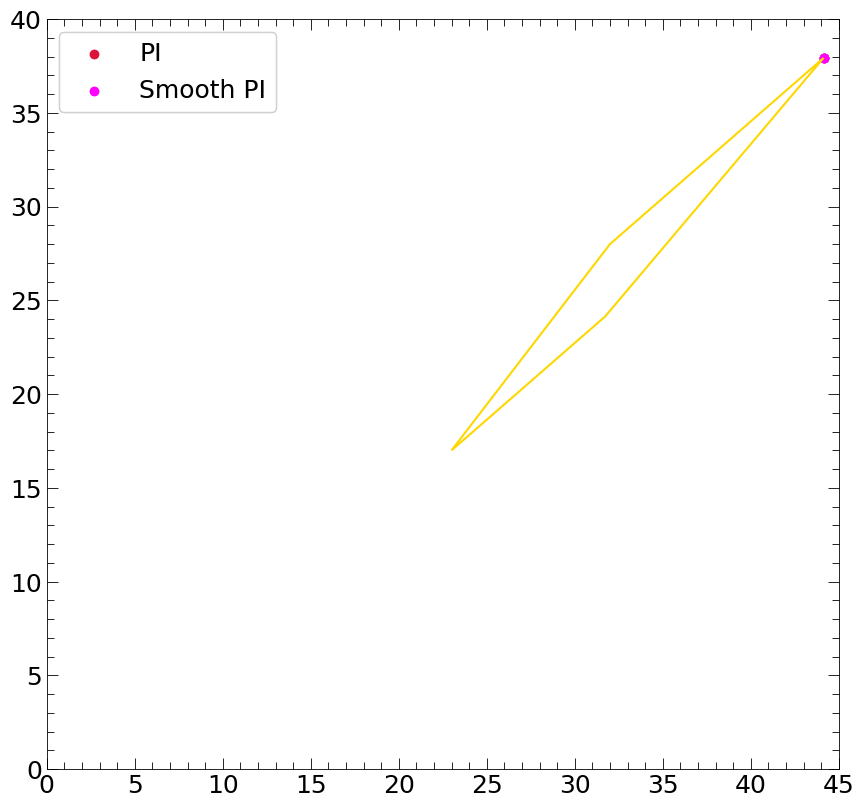

<Figure size 640x480 with 0 Axes>

In [ ]:
tau = 1e-5
P, R, gamma = generate_mdp()
ns, na = P.shape[0], P.shape[1]
init_dist = 0.5 * np.ones((ns,))

# Boundaries of the feasible set
boundaries = np.array([[23., 17.],[31.72413793, 24.13793103],[44.13793103, 37.93103448],[32., 28.]])


# Policy iteration
print('==>> 1. Policy iterations')
start = timer()
pi = []
operator = get_policy_iteration_operator(P, R, gamma)
successive_approximation(np.zeros((ns, na)), operator, policy_iteration_criterion, pi)
for i in range(len(pi)):
  pi[i] = direct_policy_evaluation(P, R, gamma, pi[i])
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(pi), end - start))

# Smooth policy iteration
print('==>> 2. Smooth policy iterations with tau = %f' %(tau))
start = timer()
spi = []
operator = get_smooth_policy_iteration_operator(P, R, gamma, tau)
successive_approximation(np.zeros((ns, na)), operator, policy_iteration_criterion, spi)
for i in range(len(spi)):
  spi[i] = direct_policy_evaluation(P, R, gamma, spi[i])
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(spi), end - start))


trajectories = [pi, spi]
labels = ['PI', 'Smooth PI']
colors = ['crimson', 'magenta']


# Set the matplotlib environment
set_plot_env()

# Plot the trajectories
plot_trajectories(boundaries, trajectories, labels, colors)

###### $\tau = 10^{-2}$

==>> 1. Policy iterations
*** Generated 2 elements. Execution time: 6.76 seconds
==>> 2. Smooth policy iterations with tau = 0.010000
*** Generated 3 elements. Execution time: 12.91 seconds


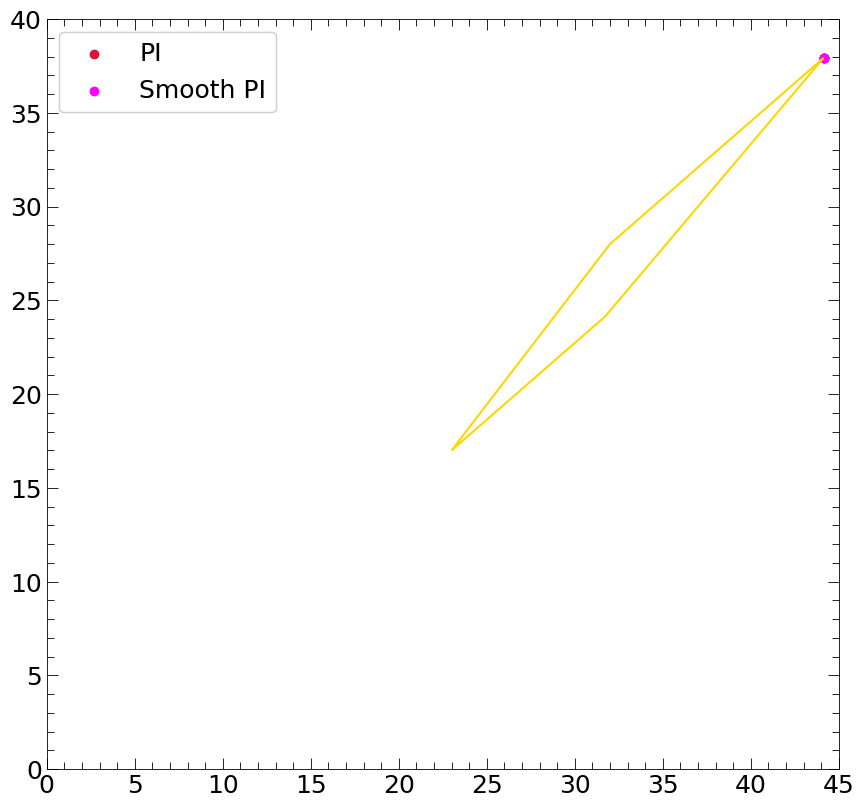

<Figure size 640x480 with 0 Axes>

In [ ]:
tau = 1e-2
P, R, gamma = generate_mdp()
ns, na = P.shape[0], P.shape[1]
init_dist = 0.5 * np.ones((ns,))

# Boundaries of the feasible set
boundaries = np.array([[23., 17.],[31.72413793, 24.13793103],[44.13793103, 37.93103448],[32., 28.]])


# Policy iteration
print('==>> 1. Policy iterations')
start = timer()
pi = []
operator = get_policy_iteration_operator(P, R, gamma)
successive_approximation(np.zeros((ns, na)), operator, policy_iteration_criterion, pi)
for i in range(len(pi)):
  pi[i] = direct_policy_evaluation(P, R, gamma, pi[i])
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(pi), end - start))

# Smooth policy iteration
print('==>> 2. Smooth policy iterations with tau = %f' %(tau))
start = timer()
spi = []
operator = get_smooth_policy_iteration_operator(P, R, gamma, tau)
successive_approximation(np.zeros((ns, na)), operator, policy_iteration_criterion, spi)
for i in range(len(spi)):
  spi[i] = direct_policy_evaluation(P, R, gamma, spi[i])
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(spi), end - start))


trajectories = [pi, spi]
labels = ['PI', 'Smooth PI']
colors = ['crimson', 'magenta']


# Set the matplotlib environment
set_plot_env()

# Plot the trajectories
plot_trajectories(boundaries, trajectories, labels, colors)

###### $\tau = 1$

==>> 1. Policy iterations
*** Generated 2 elements. Execution time: 6.56 seconds
==>> 2. Smooth policy iterations with tau = 1.000000
*** Generated 15 elements. Execution time: 91.03 seconds


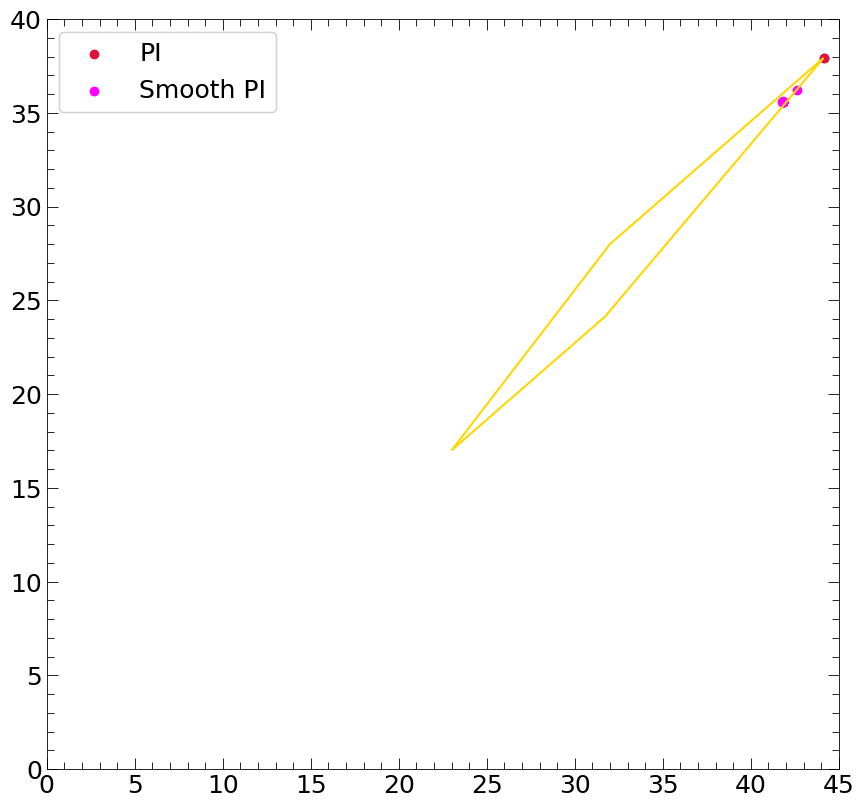

<Figure size 640x480 with 0 Axes>

In [ ]:
tau = 1.
P, R, gamma = generate_mdp()
ns, na = P.shape[0], P.shape[1]
init_dist = 0.5 * np.ones((ns,))

# Boundaries of the feasible set
boundaries = np.array([[23., 17.],[31.72413793, 24.13793103],[44.13793103, 37.93103448],[32., 28.]])


# Policy iteration
print('==>> 1. Policy iterations')
start = timer()
pi = []
operator = get_policy_iteration_operator(P, R, gamma)
successive_approximation(np.zeros((ns, na)), operator, policy_iteration_criterion, pi)
for i in range(len(pi)):
  pi[i] = direct_policy_evaluation(P, R, gamma, pi[i])
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(pi), end - start))

# Smooth policy iteration
print('==>> 2. Smooth policy iterations with tau = %f' %(tau))
start = timer()
spi = []
operator = get_smooth_policy_iteration_operator(P, R, gamma, tau)
successive_approximation(np.zeros((ns, na)), operator, policy_iteration_criterion, spi)
for i in range(len(spi)):
  spi[i] = direct_policy_evaluation(P, R, gamma, spi[i])
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(spi), end - start))


trajectories = [pi, spi]
labels = ['PI', 'Smooth PI']
colors = ['crimson', 'magenta']


# Set the matplotlib environment
set_plot_env()

# Plot the trajectories
plot_trajectories(boundaries, trajectories, labels, colors)

###### $\tau = 5$

==>> 1. Policy iterations
*** Generated 2 elements. Execution time: 6.83 seconds
==>> 2. Smooth policy iterations with tau = 5.000000
*** Generated 13 elements. Execution time: 76.97 seconds


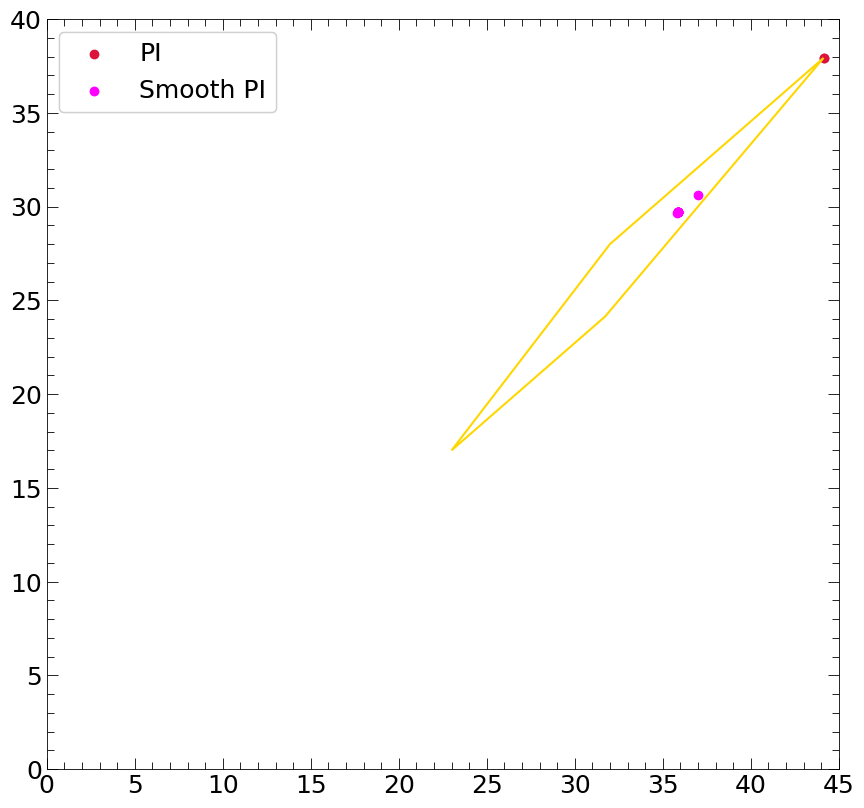

<Figure size 640x480 with 0 Axes>

In [ ]:
tau = 5. 
P, R, gamma = generate_mdp()
ns, na = P.shape[0], P.shape[1]
init_dist = 0.5 * np.ones((ns,))

# Boundaries of the feasible set
boundaries = np.array([[23., 17.],[31.72413793, 24.13793103],[44.13793103, 37.93103448],[32., 28.]])


# Policy iteration
print('==>> 1. Policy iterations')
start = timer()
pi = []
operator = get_policy_iteration_operator(P, R, gamma)
successive_approximation(np.zeros((ns, na)), operator, policy_iteration_criterion, pi)
for i in range(len(pi)):
  pi[i] = direct_policy_evaluation(P, R, gamma, pi[i])
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(pi), end - start))

# Smooth policy iteration
print('==>> 2. Smooth policy iterations with tau = %f' %(tau))
start = timer()
spi = []
operator = get_smooth_policy_iteration_operator(P, R, gamma, tau)
successive_approximation(np.zeros((ns, na)), operator, policy_iteration_criterion, spi)
for i in range(len(spi)):
  spi[i] = direct_policy_evaluation(P, R, gamma, spi[i])
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(spi), end - start))


trajectories = [pi, spi]
labels = ['PI', 'Smooth PI']
colors = ['crimson', 'magenta']


# Set the matplotlib environment
set_plot_env()

# Plot the trajectories
plot_trajectories(boundaries, trajectories, labels, colors)

###### Comment


We notice that when we increase the temperature, the smooth operator starts farther from the optimal point and performs more steps before converging. Also, higher values of temperature lead to different convergence points.

##### Plotting VI only

We are going to plot VI and smooth VI trajectories for different values of the temperature ($\tau$) to see what is the effect of increasing this parameter.

###### $\tau = 10^{-5}$

==>> 3. Value iterations
*** Generated 193 elements. Execution time: 2.88 seconds
==>> 4. Smooth value iterations with tau = 0.000010
*** Generated 193 elements. Execution time: 3.97 seconds


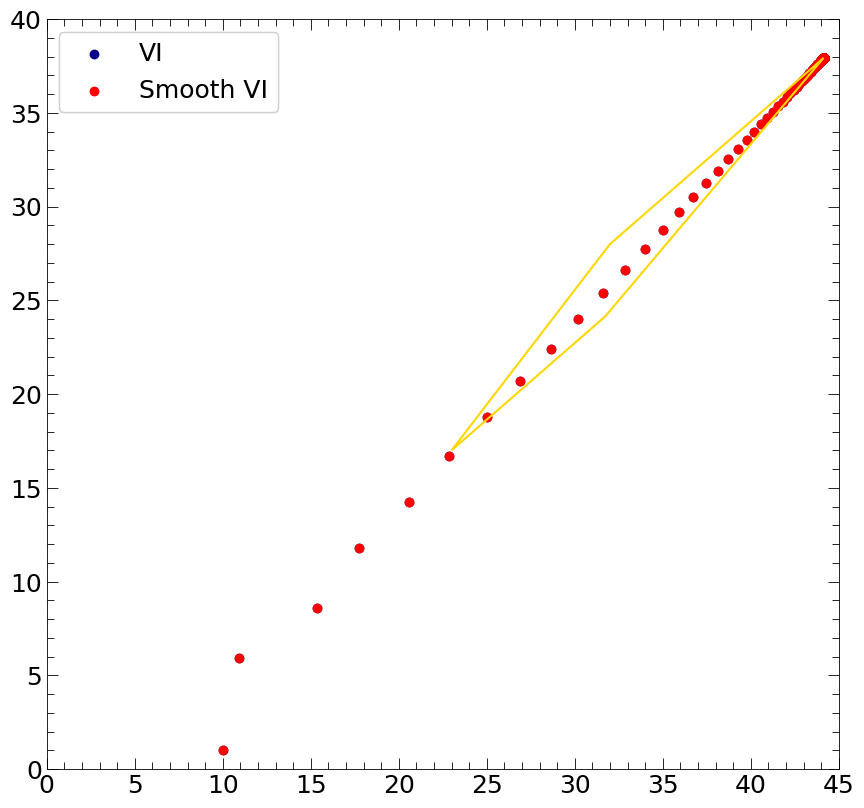

<Figure size 640x480 with 0 Axes>

In [ ]:
tau = 1e-5
P, R, gamma = generate_mdp()
ns, na = P.shape[0], P.shape[1]
init_dist = 0.5 * np.ones((ns,))

# Boundaries of the feasible set
boundaries = np.array([[23., 17.],[31.72413793, 24.13793103],[44.13793103, 37.93103448],[32., 28.]])


# Value iteration
print('==>> 3. Value iterations')
start = timer()
vi = []
operator = get_bellman_optimality_operator(P, R, gamma)
successive_approximation(np.zeros((ns,)), operator, default_criterion, vi)
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(vi), end - start))

# Smooth value iteration
print('==>> 4. Smooth value iterations with tau = %f' %(tau))
start = timer()
svi = []
operator = get_smooth_bellman_optimality_operator(P, R, gamma, tau)
successive_approximation(np.zeros((ns,)), operator, default_criterion, svi)
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(svi), end - start))


trajectories = [vi, svi]
labels = ['VI', 'Smooth VI']
colors = ['darkblue', 'red']


# Set the matplotlib environment
set_plot_env()

# Plot the trajectories
plot_trajectories(boundaries, trajectories, labels, colors)

###### $\tau = 1$

==>> 3. Value iterations
*** Generated 193 elements. Execution time: 2.80 seconds
==>> 4. Smooth value iterations with tau = 1.000000
*** Generated 193 elements. Execution time: 3.94 seconds


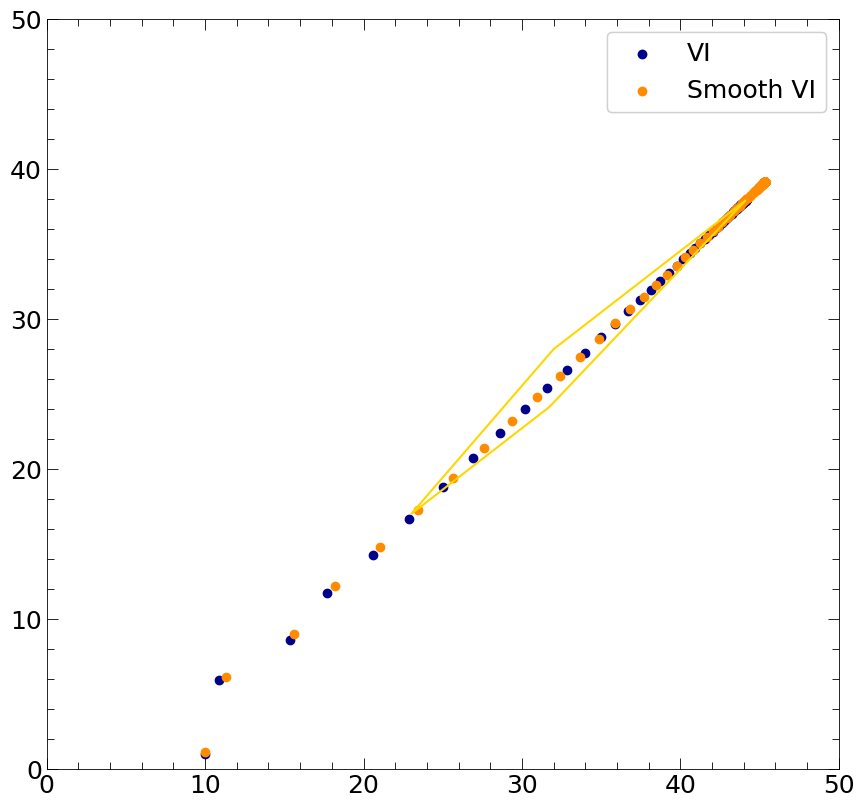

<Figure size 640x480 with 0 Axes>

In [ ]:
tau = 1.
P, R, gamma = generate_mdp()
ns, na = P.shape[0], P.shape[1]
init_dist = 0.5 * np.ones((ns,))

# Boundaries of the feasible set
boundaries = np.array([[23., 17.],[31.72413793, 24.13793103],[44.13793103, 37.93103448],[32., 28.]])


# Value iteration
print('==>> 3. Value iterations')
start = timer()
vi = []
operator = get_bellman_optimality_operator(P, R, gamma)
successive_approximation(np.zeros((ns,)), operator, default_criterion, vi)
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(vi), end - start))

# Smooth value iteration
print('==>> 4. Smooth value iterations with tau = %f' %(tau))
start = timer()
svi = []
operator = get_smooth_bellman_optimality_operator(P, R, gamma, tau)
successive_approximation(np.zeros((ns,)), operator, default_criterion, svi)
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(svi), end - start))


trajectories = [vi, svi]
labels = ['VI', 'Smooth VI']
colors = ['darkblue', 'darkorange']


# Set the matplotlib environment
set_plot_env()

# Plot the trajectories
plot_trajectories(boundaries, trajectories, labels, colors, 0, 50, 0, 50)

###### $\tau = 10$

==>> 3. Value iterations
*** Generated 193 elements. Execution time: 2.77 seconds
==>> 4. Smooth value iterations with tau = 10.000000
*** Generated 201 elements. Execution time: 4.05 seconds


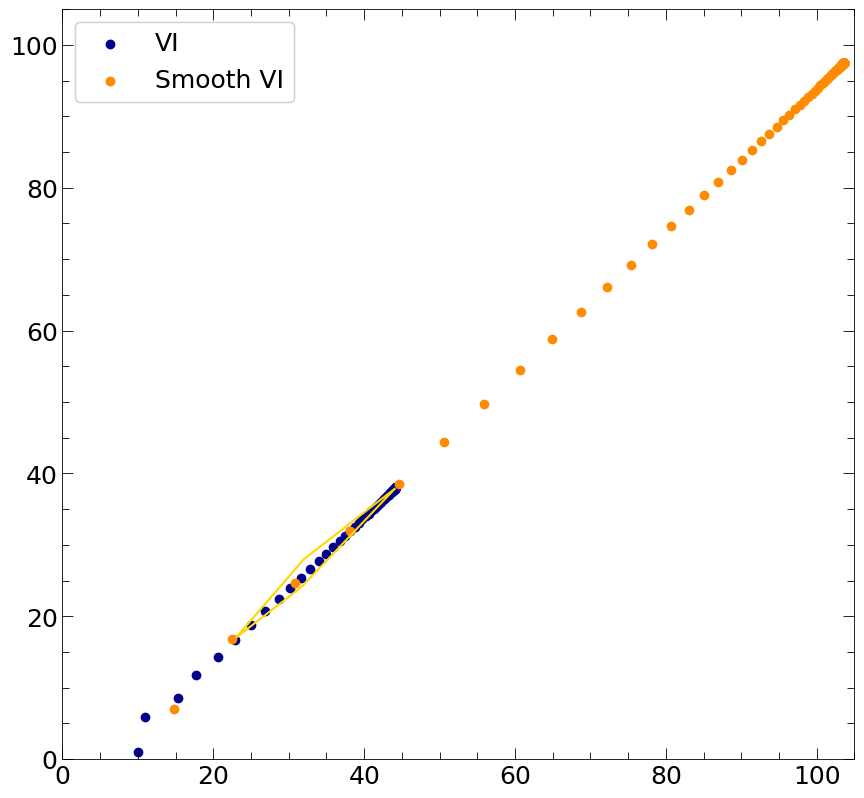

<Figure size 640x480 with 0 Axes>

In [ ]:
tau = 10
P, R, gamma = generate_mdp()
ns, na = P.shape[0], P.shape[1]
init_dist = 0.5 * np.ones((ns,))

# Boundaries of the feasible set
boundaries = np.array([[23., 17.],[31.72413793, 24.13793103],[44.13793103, 37.93103448],[32., 28.]])


# Value iteration
print('==>> 3. Value iterations')
start = timer()
vi = []
operator = get_bellman_optimality_operator(P, R, gamma)
successive_approximation(np.zeros((ns,)), operator, default_criterion, vi)
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(vi), end - start))

# Smooth value iteration
print('==>> 4. Smooth value iterations with tau = %f' %(tau))
start = timer()
svi = []
operator = get_smooth_bellman_optimality_operator(P, R, gamma, tau)
successive_approximation(np.zeros((ns,)), operator, default_criterion, svi)
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(svi), end - start))


trajectories = [vi, svi]
labels = ['VI', 'Smooth VI']
colors = ['darkblue', 'darkorange']


# Set the matplotlib environment
set_plot_env()

# Plot the trajectories
plot_trajectories(boundaries, trajectories, labels, colors, 0, 105, 0, 105)

###### Comment

We notice that when we increase the temperature:
1.  The smooth operator starts farther from the optimal point and performs more steps before converging. 
2.  The smooth operator trajectory is slightly offset from the hard operator's.
3.  When the temperature gets large enough, the smooth operator trajectory oscillates between both sides of the optimal point, getting far beyond it.

Conversely, when we decrease the temperature, we get closer to the results obtained by the hard operator. When the temperature is low, enough, the trajectories are exactely the same.

##### Plotting NK only

We are going to plot the trajectories of the NK operator for different values of the temperature ($\tau$) to see what is the effect of increasing this parameter.

###### $\tau \in \{10^{-5}, 10^{-2}, 1, 10, 15\}$

==>> 5. Newton Kantorovich iterations with tau = 0.000010
*** Generated 2 elements. Execution time: 7.17 seconds
==>> 5. Newton Kantorovich iterations with tau = 1.000000
*** Generated 4 elements. Execution time: 14.21 seconds
==>> 5. Newton Kantorovich iterations with tau = 10.000000
*** Generated 4 elements. Execution time: 15.02 seconds
==>> 5. Newton Kantorovich iterations with tau = 15.000000
*** Generated 4 elements. Execution time: 15.54 seconds


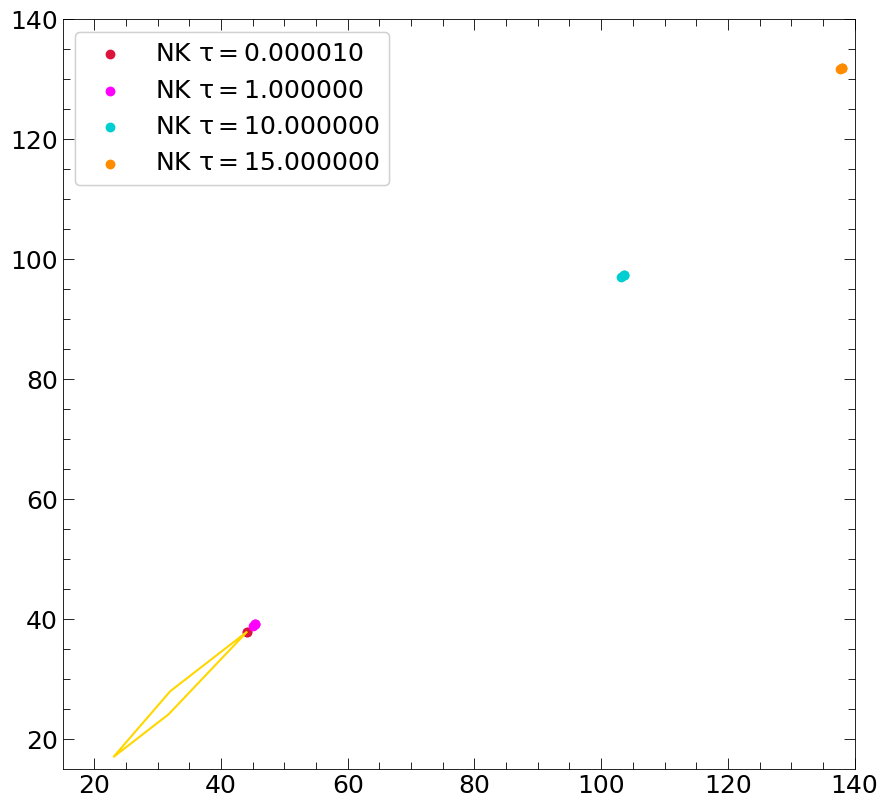

<Figure size 640x480 with 0 Axes>

In [ ]:
tau_arr = [1e-5, 1., 10., 15.]
P, R, gamma = generate_mdp()
ns, na = P.shape[0], P.shape[1]
init_dist = 0.5 * np.ones((ns,))

# Boundaries of the feasible set
boundaries = np.array([[23., 17.],[31.72413793, 24.13793103],[44.13793103, 37.93103448],[32., 28.]])

trajectories = []
labels = []
colors = ['crimson', 'magenta', 'darkturquoise', 'darkorange']


# Newton-Kantorovich iterations
for tau in tau_arr:
  print('==>> 5. Newton Kantorovich iterations with tau = %f' %tau)
  start = timer()
  nk = []
  smooth_operator = get_smooth_bellman_optimality_operator(P, R, gamma, tau)
  gateaux_derivative = get_gateaux_derivative(P, R, gamma, tau)
  operator = get_newton_kantorovich_operator(smooth_operator, gateaux_derivative)
  successive_approximation(np.zeros((ns,)), operator, default_criterion, nk)
  end = timer()
  print('*** Generated %d elements. Execution time: %.2f seconds' %(len(nk), end - start))
  trajectories.append(nk)
  labels.append(r'NK $\tau = %f$' %tau)


# Set the matplotlib environment
set_plot_env()

# Plot the trajectorWe are going to plot VI and smooth VI trajectories for different values of the temperature ($\tau$) to see what is the effect of increasing this parameter.We are going to plot VI and smooth VI trajectories for different values of the temperature ($\tau$) to see what is the effect of increasing this parameter.ies
plot_trajectories(boundaries, trajectories, labels, colors, 15, 140, 15, 140)

Let' have a closer look at the different trajectories:

In [ ]:
for i in range(len(trajectories)):
  print(trajectories[i])

[DeviceArray([44.13793098, 37.93103442], dtype=float64), DeviceArray([44.13793098, 37.93103442], dtype=float64)]
[DeviceArray([45.02133814, 38.8846003 ], dtype=float64), DeviceArray([45.31894533, 39.1280971 ], dtype=float64), DeviceArray([45.31904698, 39.12818027], dtype=float64), DeviceArray([45.31904698, 39.12818027], dtype=float64)]
[DeviceArray([103.15219871,  97.09068747], dtype=float64), DeviceArray([103.54425655,  97.41146207], dtype=float64), DeviceArray([103.54431242,  97.41150778], dtype=float64), DeviceArray([103.54431242,  97.41150778], dtype=float64)]
[DeviceArray([137.74583984, 131.66571692], dtype=float64), DeviceArray([138.01692031, 131.88751003], dtype=float64), DeviceArray([138.01693837, 131.8875248 ], dtype=float64), DeviceArray([138.01693837, 131.8875248 ], dtype=float64)]


###### Comment

We notice the following:

1. The more we increase the temperature, the farther the operator gets from the optimal point. 
2. The procedure takes more steps to converge for high values of the temperature.
3. The increase of temperature leads to different values of convergence points.

The results above are consistent with the theoritical hypotheses and assumptions of Newton's method: the convergence is guaranteed only if we start close enough to the optimal value (the actual solution). Increasing the temperature leads to generating values far away the optimal point, which leads to convergence towards other points in the value space.

At last but not least, this method is similar to PI in the sense that they both perform few iterations around the optimal value (they visit the same points for low values of temperature). However, if increasing the temperature leads to different convergence points for both methods, the difference is that for PI, the convergence points are lower(in terms of coordinates) than the optimal point, while for the NK method they are higher.

##### Plotting simplex only

==>> 6. Simplex iterations
*** Generated 6 elements. Execution time: 0.06 seconds


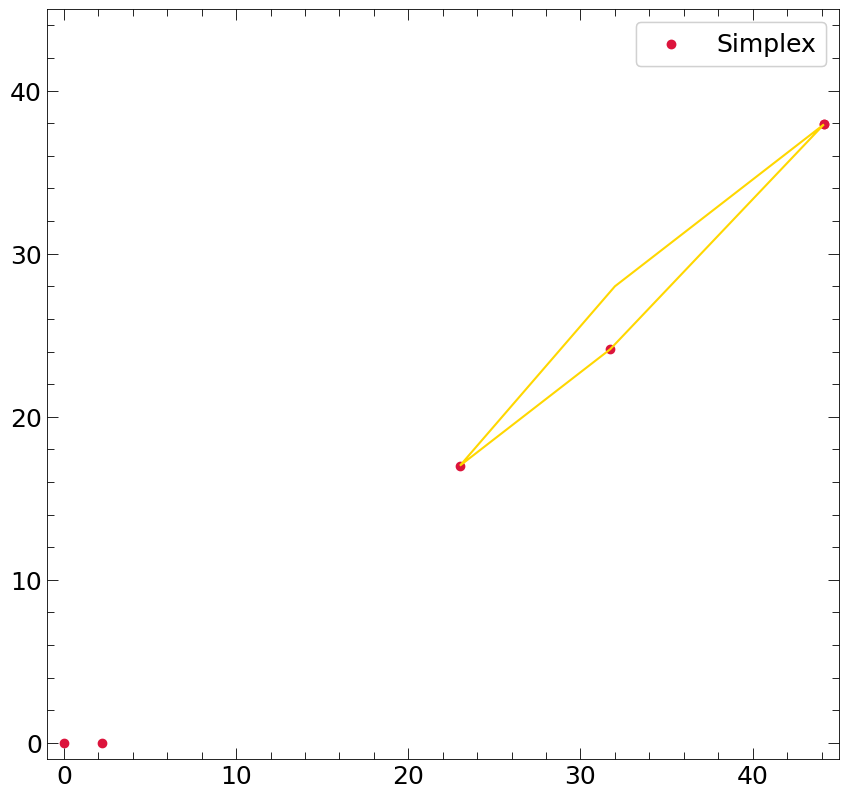

<Figure size 640x480 with 0 Axes>

In [ ]:
P, R, gamma = generate_mdp()
ns, na = P.shape[0], P.shape[1]
init_dist = 0.5 * np.ones((ns,))

# Boundaries of the feasible set
boundaries = np.array([[23., 17.],[31.72413793, 24.13793103],[44.13793103, 37.93103448],[32., 28.]])

# LP 
print('==>> 6. Simplex iterations')
sim = []
start = timer()
res = solve_lp(P, R, gamma, init_dist, solver = 'revised simplex', trace_back_list = sim)
end = timer()
print('*** Generated %d elements. Execution time: %.2f seconds' %(len(sim), end - start))

# Data sets

trajectories = [sim]
labels = ['Simplex']
colors = ['crimson']


# Set the matplotlib environment
set_plot_env()

# Plot the trajectories
plot_trajectories(boundaries, trajectories, labels, colors, -1, 45, -1, 45)

###### Comment

The simplex algorithm is the fastest in terms of execution time, and among the most efficient algorithms in terms of number of steps. We can notice that once it gets within the boundaries of the feasible set, it visits the corners until it reaches the optimal solution. 

#### (i)

As we can see in the plots above, decreasing the temperature for smooth operators lead their trajectories to overlap with their 'hard' counterparts'. This corroborates the Dini's theorem that we have already seen in class: indeed, assuming $L$ is the Bellman operator and $\Gamma_\tau$ the smoothed Bellman operator ($\tau$ is the temperature), then we have: 
\begin{align*}
    \lim_{\tau \to 0} \Gamma_\tau v = Lv \enspace
\end{align*} 

#### (ii)

**Results**

This is to summarize and analyze the plots we have obtained in the experiments above. As a reminder, we have tested the following algorithms:
1. Policy iteration (PI).
2. Smooth policy iteration.
3. Value iteration (VI).
4. Smooth value iteration.
5. Newton-Kantorovich (NK) iterations.
6. Simplex.

The following bullet-points summarize our immediate observations:
1. Each of PI, smooth PI and NK find the optimal solution almost immediately. They remain around the optimal value before terminating. 
2. PI, smooth PI and NK trajectories are identical.
3. VI and smooth VI (we used a very small $\tau$) trajectories overlap on every point. 
4. VI and smooth VI start from beyond the feasible set boundaries before converging to the optimal value.
5. The simplex algorithm starts from beyond the boundaries but quickly converges to the optimal value.
6. The VI operator perform much more steps than other algorithms.
7. The simplex algorithm seems to be the fastest among all others.

Looking closer as the effect of the temperature($\tau$), we noted that:
1. Increasing $\tau$ yields the effect of making 'smooth' trajectories diverge from the 'hard' ones.
2. Reducing $\tau$ yields the effect of making 'smooth' trajectories overlap with the 'hard' ones.
3. Increasing $\tau$ makes smooth PI, smooth VI and NK converge to the wrong value.
4. Reducing $\tau$ makes smooth PI, smooth VI and NK converge to the optimal value.

At last but not least, it should be noted that the simplex algorithms selects a unique (yet short) path towards the optimal point: it starts away of the feasible set but quickly reaches it. Once in the polygon, the algorithm travels from vertex to vertex until reaching the optimal point.

**Discussion**

In this section, we suggest comments/interpretations regarding the above observations. Let's start with the visualization part:
1. The closeness between the smooth and non-smooth operators is certainly due to the temperature we initially have chosen 
   ($\tau \approx 10^{-5}$). Indeed, the smaller the temperature, the closer we get to the non-smooth operator. 
2. Each of PI, smooth PI and NK get almost immediately around the optimal value, however, they do some iterations before getting in it. 
    This is partly due to the hard constraints we put on the termination condition ($\epsilon \approx 10^{-5}$). Should the $\epsilon$ has been a bit bigger, we would have seen an immediate convergence to the optimal point.  
3. Policies usually converge faster than values (we are in a finite MDP with a small set of deterministic policies), whic explains the big 
   difference between the number of steps taken by both of VI and PI operators.
4. The PI, smooth PI and NK visit the exact same points. As shown by Martin Puterman in [his article]( https://www.jstor.org/stable/3689239 ), PI and NK are - under some assumptions - completely  equivalent algorithms.
5. As mentioned before, decreasing the temperature in the smooth operators pushes them closer and closer to the hard ones. Conversely, increasing the temperature significantly alters the values and thus leads the algorithm toward other stationary points.
6. Due to its particular implementation ([Gaussian elimination](https://en.wikipedia.org/wiki/Gaussian_elimination)), the simplex algorithm usually travels from vertex to vertex if it starts from inside the polygon defining the basic feasible set. However in this particular case, we have defined the starting point as the **null vector** (to be able to perform fair comparison with the other algorithms). As we starts way far from the feasible set, it is normal that the first two points the simplex algorithm visits are outside of the basic feasible set.
